In [13]:
# !pip install opencv-python --quiet

In [14]:
# !pip install torch --quiet

In [15]:
# !pip install albumentations --user

In [16]:
import pandas as pd
import numpy as np

import os
import torchvision
import torch

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics, model_selection

import cv2
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset

from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt


In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [18]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 128

## Preparing Data

In [19]:
import pandas as pd
df_train_data = pd.read_csv('/Users/alexshienhowkhoo/Documents/SC4000 Project/dataset/train.csv')
df_train_data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


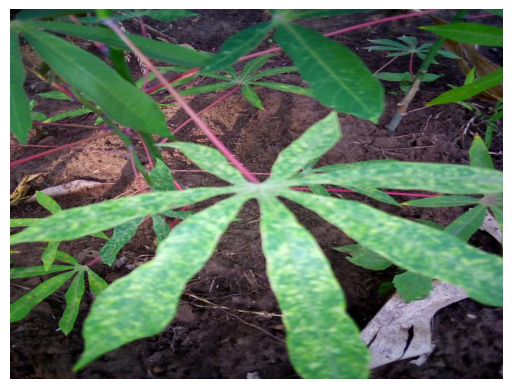

In [20]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = '/Users/alexshienhowkhoo/Documents/SC4000 Project/dataset/train_images'

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [21]:
unique_labels = df_train_data.label.value_counts()
num_unique_labels = unique_labels.nunique()


In [22]:
from sklearn import metrics, model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["label"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [23]:
from torch.utils.data import Dataset

class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [24]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [25]:
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [26]:
def calc_mean_std(train_df, trainloader): 
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    
    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]   
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 151/151 [01:12<00:00,  2.09it/s]


In [27]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])
train_df = ConstDataset(df_train, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [28]:
# trainloader = torch.utils.data.DataLoader(train_df, batch_size=4,
#                                           shuffle=True, num_workers=0)
# torch.manual_seed(124)
# for batch_idx, data in enumerate(trainloader,0):
#     if(batch_idx==0): 
#         input, label = data 
#         print(type(input))
#         print(input[0].shape)
#         print(input[0])
#         plt.imshow(input[0].numpy().transpose(1,2,0))
#     break;



In [29]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0), 
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [30]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
num_classes = num_unique_labels
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [31]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


In [33]:
!pip install tensorflow-macos
 # Use all parameters


In [34]:
!pip install tensorflow-macos


In [35]:
# Define device (MPS or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)

In [36]:
for epoch in range(epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs, labels = inputs.to(device),labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            with torch.set_grad_enabled(phase == 'train'):
                _, preds = torch.max(outputs, 1)
  
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        if phase == 'train': 
            epoch_loss = running_loss / len(train_df)
            epoch_acc = running_corrects.float() / len(train_df)
        else: 
            epoch_loss = running_loss / len(valid_df)
            epoch_acc = running_corrects.float() / len(valid_df)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.1183 Acc: 0.6087
val Loss: 1.0342 Acc: 0.6388
train Loss: 1.0011 Acc: 0.6424
val Loss: 0.9808 Acc: 0.6500
train Loss: 0.9652 Acc: 0.6512
val Loss: 0.9637 Acc: 0.6556
train Loss: 0.9371 Acc: 0.6582
val Loss: 0.9421 Acc: 0.6547
train Loss: 0.9244 Acc: 0.6619
val Loss: 0.9401 Acc: 0.6607
train Loss: 0.9120 Acc: 0.6644
val Loss: 0.9141 Acc: 0.6668
train Loss: 0.9009 Acc: 0.6710
val Loss: 0.9097 Acc: 0.6813
train Loss: 0.8890 Acc: 0.6726
val Loss: 0.9135 Acc: 0.6678
train Loss: 0.8848 Acc: 0.6763
val Loss: 0.8925 Acc: 0.6654
train Loss: 0.8779 Acc: 0.6771
val Loss: 0.8899 Acc: 0.6706
train Loss: 0.8731 Acc: 0.6793
val Loss: 0.8981 Acc: 0.6706
train Loss: 0.8678 Acc: 0.6784
val Loss: 0.8917 Acc: 0.6785
train Loss: 0.8604 Acc: 0.6846
val Loss: 0.8854 Acc: 0.6766
train Loss: 0.8572 Acc: 0.6833
val Loss: 0.8818 Acc: 0.6804
train Loss: 0.8527 Acc: 0.6871
val Loss: 0.8791 Acc: 0.6813
train Loss: 0.8545 Acc: 0.6830
val Loss: 0.8915 Acc: 0.6818
Training complete!


In [37]:
# Define the path where you want to save the model
save_path = './trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to ./trained_model.pth
